# User-Based Collaborative Filtering

In [13]:
!pip install -q -U scikit-surprise
!pip install -q numpy==1.26.4

In [14]:
import pandas as pd
from surprise.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import Divider, Size

# Helper Functions

In [15]:
from collections import defaultdict

def get_top_k(predictions, k=10):
    '''Return the top-K recommended items for each user from predictions.'''
    top_k = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_k[uid].append((iid, est))

    # Sort and pick top k
    for uid, user_ratings in top_k.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_k[uid] = [iid for (iid, _) in user_ratings[:k]]

    return top_k

In [16]:
def get_true_positives(testset, threshold=4.0):
    '''Return items considered relevant per user from the testset.'''
    relevant = defaultdict(set)
    for uid, iid, true_r in testset:
        if true_r >= threshold:
            relevant[uid].add(iid)
    return relevant

In [17]:
def precision_at_k(top_k_preds, relevant_items, k):
    precisions = []
    for uid in top_k_preds:
        if uid in relevant_items:
            hits = len(set(top_k_preds[uid]) & relevant_items[uid])
            precisions.append(hits / k)

    if len(precisions) == 0:
        print("Warning: No overlap between predicted users and relevant users.")
        return 0.0

    return sum(precisions) / len(precisions)

def hit_rate_at_k(top_k_preds, relevant_items):
    hits = 0
    total = 0
    for uid in relevant_items:
        total += 1
        if set(top_k_preds[uid]) & relevant_items[uid]:
            hits += 1

    if hits == 0:
        print("Warning: No overlap between predicted users and relevant users.")
        return 0.0
    return hits / total

# Setting the seed for reprodcuibility

In [18]:
# we set a random seed here to make the results in this notebook reproducible
import random
import numpy as np

my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

# Reading data

In [19]:
df_train = pd.read_csv('../data/rec_train_preprocessed_binned.csv')
df_train.head()

,beer_id,username,date,text,look,smell,taste,feel,overall,score,sentiment,has_look,has_smell,has_taste,has_feel,mentioned_aspects,score_bin
0,62040,GregSVT,2010-10-29,22oz bomber snifter a: pours murky amber nice ...,4.00,4.50,4.50,4.00,4.00,4.32,positive,True,True,True,True,"look, smell, taste, feel","[4.0, 4.5)"
1,292393,NeroFiddled,2018-08-09,"avery brewing co. ""bug zapper"" 12 fl. oz. can,...",4.25,4.00,4.25,4.25,4.00,4.14,positive,True,True,True,True,"look, smell, taste, feel","[4.0, 4.5)"
2,55291,matjack85,2011-07-06,"found single, clear, 330ml bottle binny's stor...",2.00,2.00,2.00,2.00,1.50,1.90,negative,True,True,True,True,"look, smell, taste, feel","[1.5, 2.0)"
3,223330,BlurryVisi0n,2016-07-21,served chalice glass bottle cerveceria esparte...,4.00,4.25,4.00,4.50,4.00,4.11,positive,True,True,True,True,"look, smell, taste, feel","[4.0, 4.5)"
4,222637,Brutaltruth,2018-09-18,12 oz bottle snifter. decent bock pours nice c...,4.25,3.25,3.25,3.50,3.25,3.34,neutral,True,True,True,True,"look, smell, taste, feel","[3.0, 3.5)"


In [20]:
df_test = pd.read_csv('../data/rec_test_preprocessed_binned.csv')
df_test.head()

,beer_id,username,date,text,look,smell,taste,feel,overall,score,sentiment,has_look,has_smell,has_taste,has_feel,mentioned_aspects,score_bin
0,5728,jvgoor3786,2016-04-03,poured twist-top 12 ounce bottle julian date 1...,1.5,1.5,1.5,1.5,1.5,1.50,negative,True,True,True,True,"look, smell, taste, feel","[1.5, 2.0)"
1,93470,Jeffo,2015-12-10,got one hopsolutely past summer. cheers! pint ...,3.0,4.0,3.5,3.5,3.5,3.59,neutral,True,True,True,True,"look, smell, taste, feel","[3.5, 4.0)"
2,2415,wspscott,2010-07-08,12oz bottle sam adams glass (best aug 2010) ma...,4.0,2.0,2.0,3.0,2.0,2.22,neutral,True,True,True,True,"look, smell, taste, feel","[2.0, 2.5)"
3,17932,TobiasGoth,2011-09-06,appearance bartender pulls sparkling easter ye...,3.0,3.0,3.0,3.5,3.5,3.15,neutral,True,True,True,True,"look, smell, taste, feel","[3.0, 3.5)"
4,4700,nlmartin,2006-04-24,beer purchased jungle jims $1.69. beer poured ...,3.5,3.5,3.5,3.5,4.0,3.60,neutral,True,True,True,True,"look, smell, taste, feel","[3.5, 4.0)"


In [21]:
df_train = df_train[['beer_id', 'username', 'score']]
df_train.head()

,beer_id,username,score
0,62040,GregSVT,4.32
1,292393,NeroFiddled,4.14
2,55291,matjack85,1.90
3,223330,BlurryVisi0n,4.11
4,222637,Brutaltruth,3.34


In [22]:
df_test = df_test[['beer_id', 'username', 'score']]
df_test.head()

,beer_id,username,score
0,5728,jvgoor3786,1.50
1,93470,Jeffo,3.59
2,2415,wspscott,2.22
3,17932,TobiasGoth,3.15
4,4700,nlmartin,3.60


# Training 

In [23]:
from surprise import Reader, Dataset, KNNBasic
reader = Reader(rating_scale=(0, 5))

# Convert df_train into Surprise's internal training format
data = Dataset.load_from_df(df_train[['username', 'beer_id', 'score']], reader)
trainset = data.build_full_trainset()

# Convert df_test into Surprise's expected testset format
testset = list(df_test[['username', 'beer_id', 'score']].itertuples(index=False, name=None))

In [24]:
sim_options = {'name': 'pearson', 'user_based': True, 'min_support': 1}

In [25]:
algo = KNNBasic(sim_options=sim_options)
algo.fit(trainset)
predictions = algo.test(testset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [26]:
from surprise import KNNWithMeans
algo2 = KNNWithMeans(sim_options=sim_options)
algo2.fit(trainset)
predictions2 = algo2.test(testset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [27]:
from surprise import KNNWithZScore
algo3 = KNNWithZScore(sim_options=sim_options)
algo3.fit(trainset)
predictions3 = algo3.test(testset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [28]:
from surprise import KNNBaseline
algo_baseline = KNNBaseline(sim_options=sim_options)
algo_baseline.fit(trainset)
predictions_baseline = algo_baseline.test(testset)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


# Evaluation

In [29]:
metrics = ['RMSE', 'MAE', 'MSE']

In [30]:
from surprise.accuracy import mse, rmse, mae
# Compute MSE, RMSE and MAE on the test set predictions
def evaluate_recommender(predictions):
    mse_score = mse(predictions, verbose=False)
    rmse_score = rmse(predictions, verbose=False)
    mae_score = mae(predictions, verbose=False)
    return rmse_score, mae_score, mse_score

In [31]:
import matplotlib.pyplot as plt

def plot_predictions(predictions, metrics, model_name=""):
    rmse_score, mse_score, mae_score = predictions
    fig, ax = plt.subplots(figsize=(12, 6))  

    # Add title with model name
    ax.set_title(f"Evaluation Metrics for {model_name}", fontsize=14)

    ax.set_ylabel("Score")
    ax.set_xlabel("Metric")
    ax.set_ylim(0, 5)
    ax.set_xticks(range(len(metrics)))
    ax.set_xticklabels(metrics)

    # Draw bar chart
    ax.bar(range(len(metrics)), [rmse_score, mae_score, mse_score], color=['blue', 'orange', 'green'])

    # Add value labels
    for i, value in enumerate([rmse_score, mse_score, mae_score]):
        ax.text(i - 0.1, value + 0.02, str(round(value, 2)), color='black', fontweight='bold')

    # Add horizontal gridlines
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()

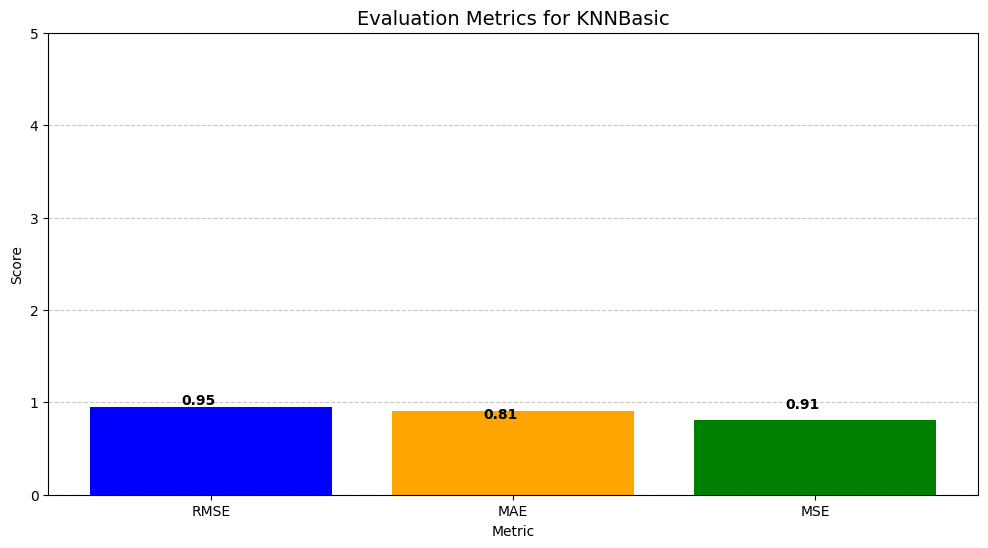

In [32]:
# Plot the metrics rmse, mse and mae
results = evaluate_recommender(predictions)
plot_predictions(results, metrics, model_name= "KNNBasic")

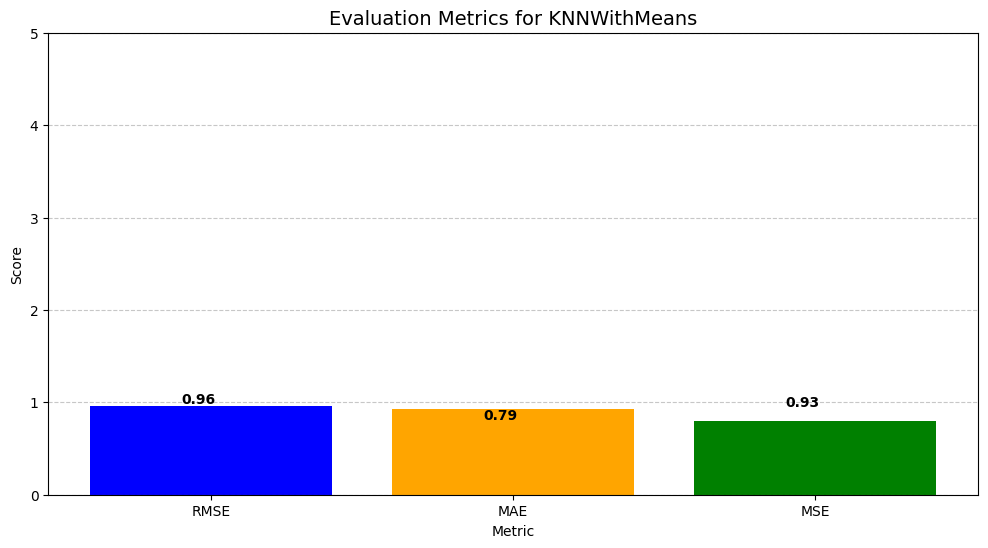

In [33]:
results2 = evaluate_recommender(predictions2)
plot_predictions(results2, metrics, model_name= "KNNWithMeans")

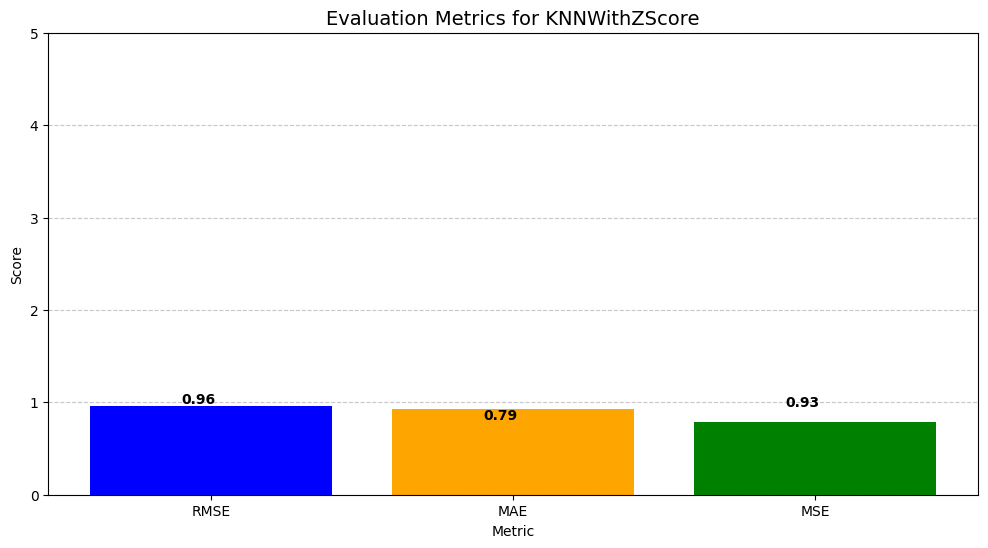

In [34]:
results3 = evaluate_recommender(predictions3)
plot_predictions(results3, metrics, model_name= "KNNWithZScore")

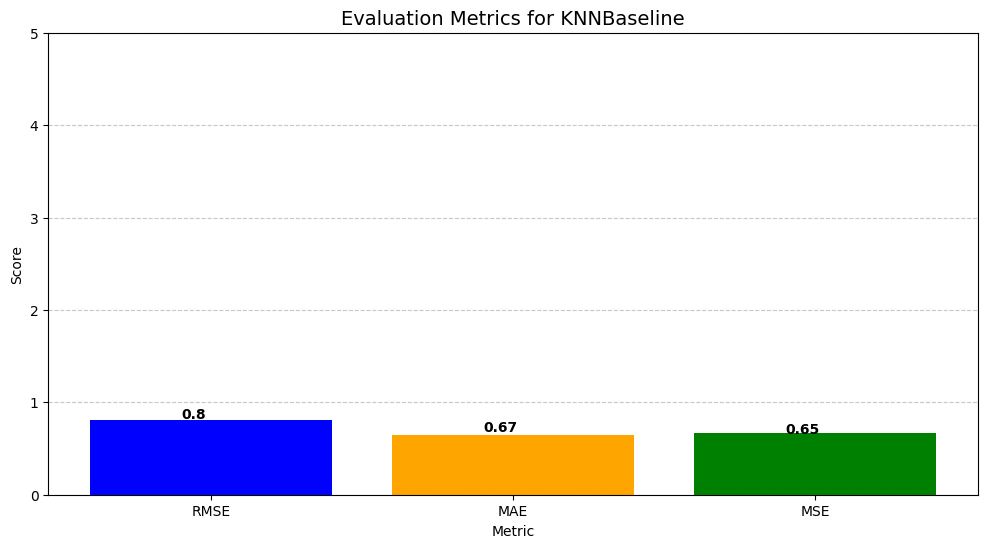

In [35]:
results_baseline = evaluate_recommender(predictions_baseline)
plot_predictions(results_baseline, metrics, model_name= "KNNBaseline")

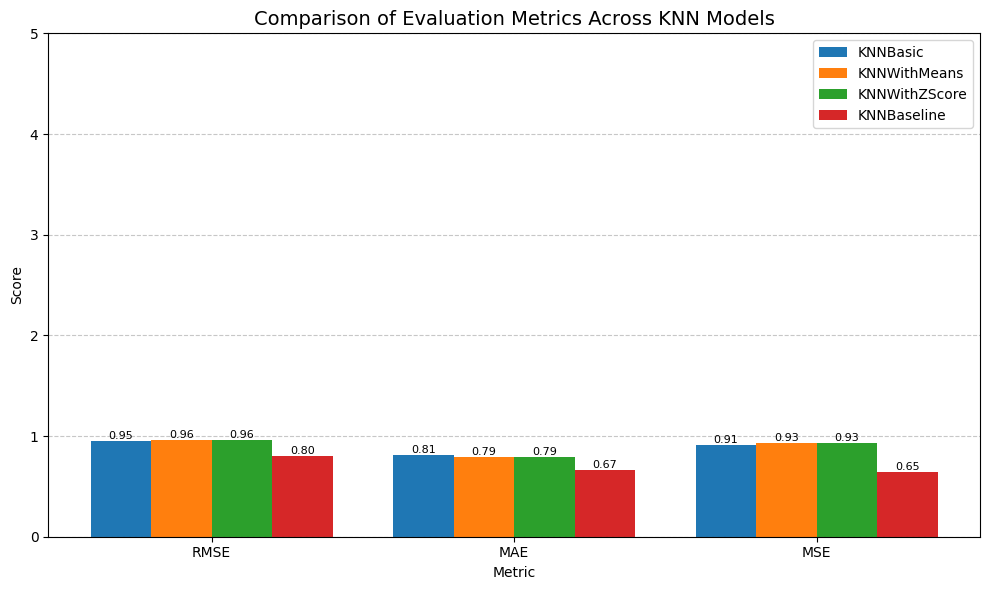

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Define metric labels in correct order
metrics = ['RMSE', 'MAE', 'MSE']

# Evaluate all model predictions using updated order
scores_basic = evaluate_recommender(predictions)               # KNNBasic
scores_with_means = evaluate_recommender(predictions2)         # KNNWithMeans
scores_zscore = evaluate_recommender(predictions3)             # KNNWithZScore
scores_baseline = evaluate_recommender(predictions_baseline)   # KNNBaseline

model_names = ['KNNBasic', 'KNNWithMeans', 'KNNWithZScore', 'KNNBaseline']
all_scores = [scores_basic, scores_with_means, scores_zscore, scores_baseline]

# Convert to numpy array for plotting
score_matrix = np.array(all_scores)  # shape: (4 models, 3 metrics)
bar_width = 0.2
x = np.arange(len(metrics))

# Plot grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))
for i, scores in enumerate(score_matrix):
    ax.bar(x + i * bar_width, scores, width=bar_width, label=model_names[i])

# Step 5: Customize chart
ax.set_title("Comparison of Evaluation Metrics Across KNN Models", fontsize=14)
ax.set_xlabel("Metric")
ax.set_ylabel("Score")
ax.set_xticks(x + 1.5 * bar_width)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 5)
ax.legend()

# Add value labels
for i in range(len(model_names)):
    for j in range(len(metrics)):
        value = score_matrix[i][j]
        ax.text(x[j] + i * bar_width, value + 0.02, f'{value:.2f}', ha='center', fontsize=8)

ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [37]:
K = 10
top_k_preds = get_top_k(predictions, k=K)
relevant_items = get_true_positives(testset, threshold=4.0)

prec = precision_at_k(top_k_preds, relevant_items, k=K)
hit = hit_rate_at_k(top_k_preds, relevant_items)

print(f'Precision@{K}: {prec:.4f}')
print(f'Hit Rate@{K}: {hit:.4f}')

Precision@10: 0.1314
Hit Rate@10: 1.0000


# Evaluation Summary (Without Sentiment Score)

### User-Based
- **Best Model:** KNNBaseline  
- **Metrics:** RMSE = 0.8, MAE = 0.67, MSE = 0.65